In [2]:
%load_ext autoreload
%autoreload 2

import os, sys
import numpy as np
import matplotlib.pyplot as plt
root_path = os.path.realpath('../')
sys.path.append(root_path)
from utils import eval, choicemodel, plotting
from hebbcl.parameters import parser

plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.use14corefonts'] = True


## Figure 1: Experiment design and baselines

In [ ]:
plotting.plot_basicstats(models=["baseline_interleaved_new_select", "baseline_blocked_new_select"])

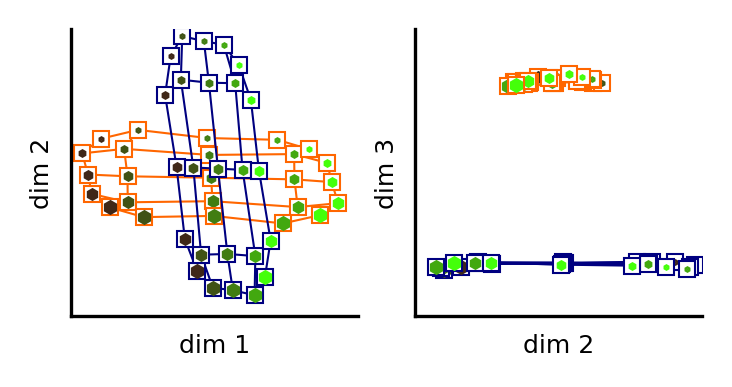

In [34]:
plotting.plot_mds(filename_embedding="mds_embedding_baseline_int_new",filename_runs= "baseline_interleaved_new_select", thetas=(40,0,10), layer="all_y_hidden", n_runs=50, resultsdir="../results/")


In [ ]:

plotting.plot_mds(filename_embedding="mds_embedding_baseline_blocked_new", filename_runs = "baseline_blocked_new_select", thetas=(-10,-10, -70), layer="all_y_hidden", n_runs=50, resultsdir="../results/")



## Figure 2: The cost of interleaving

In [ ]:
# choice matrix models

%matplotlib inline
_,_,cmats = eval.gen_behav_models()

f,ax = plt.subplots(2,2, figsize=(2,2),dpi=300)
for i in range(2):
    for j in range(2):
        ax[i,j].imshow(np.flipud(cmats[i,j,:,:]))
        if j<1:
            ax[i,j].set(xlabel='rel',ylabel='irrel')
        else:
            ax[i,j].set(xlabel='irrel',ylabel='rel')
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])


In [ ]:
# accuracy (sluggishness)
% matplotlib inline

plotting.plot_sluggish_results(filename="sluggish_baseline_int_select_sv")

## Figure 3: continual learning with manual gating

In [ ]:
plotting.plot_basicstats(models = "gated_blocked_new_select_cent")

In [ ]:
plotting.plot_mds(filename_embedding="mds_embedding_gated_blocked_new",filename_runs= "gated_blocked_new_select_cent", thetas=(-20,-20,-150), layer="all_y_hidden", n_runs=50, resultsdir="../results/")


## Figure 4: Hebbian learning of context weights (Oja on all hidden units)

In [ ]:
plotting.biplot_dataset(ds="blobs",ctx_scaling=6)

In [ ]:
plotting.plot_oja(n_hidden=1, ds="blobs")

In [ ]:
plotting.plot_oja(n_hidden=1, ds="trees")

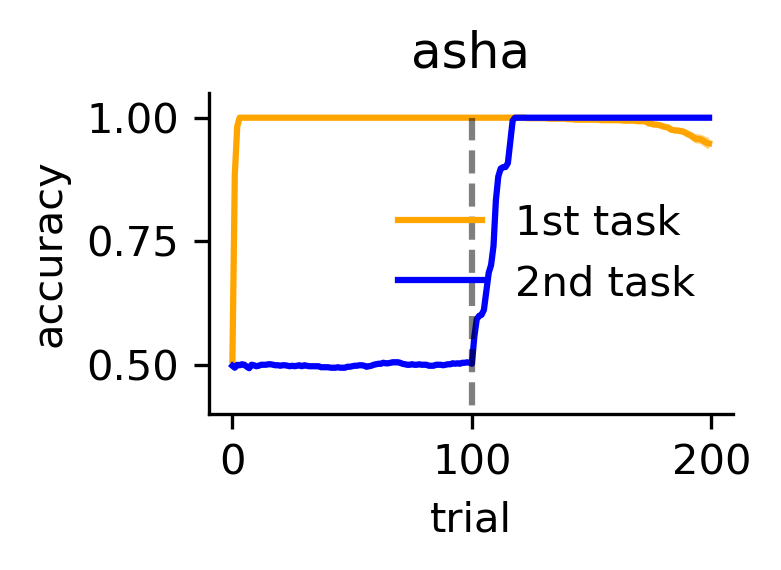

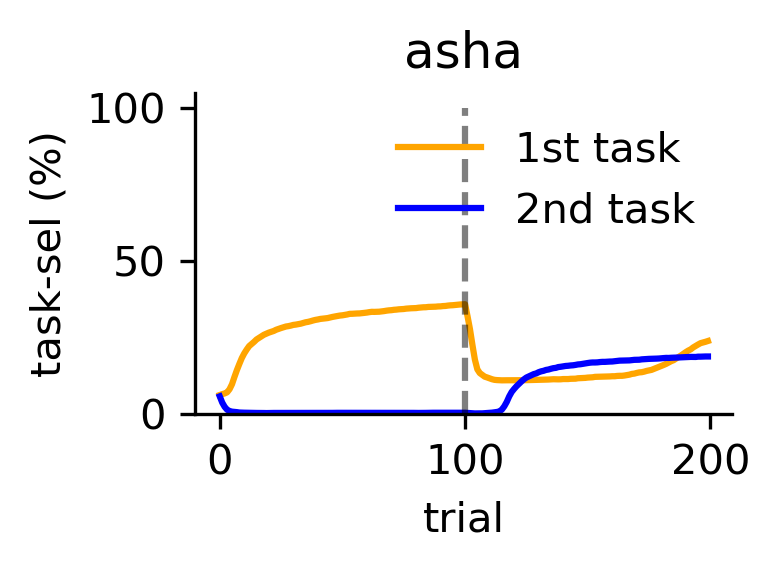

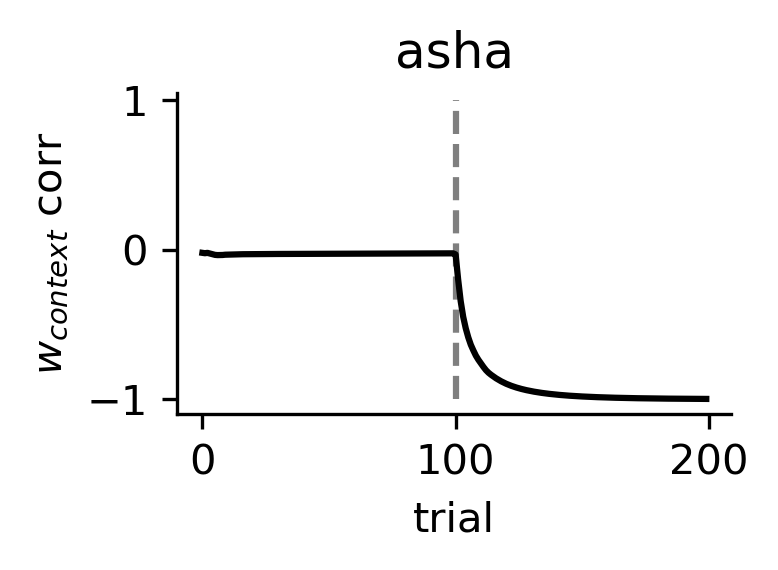

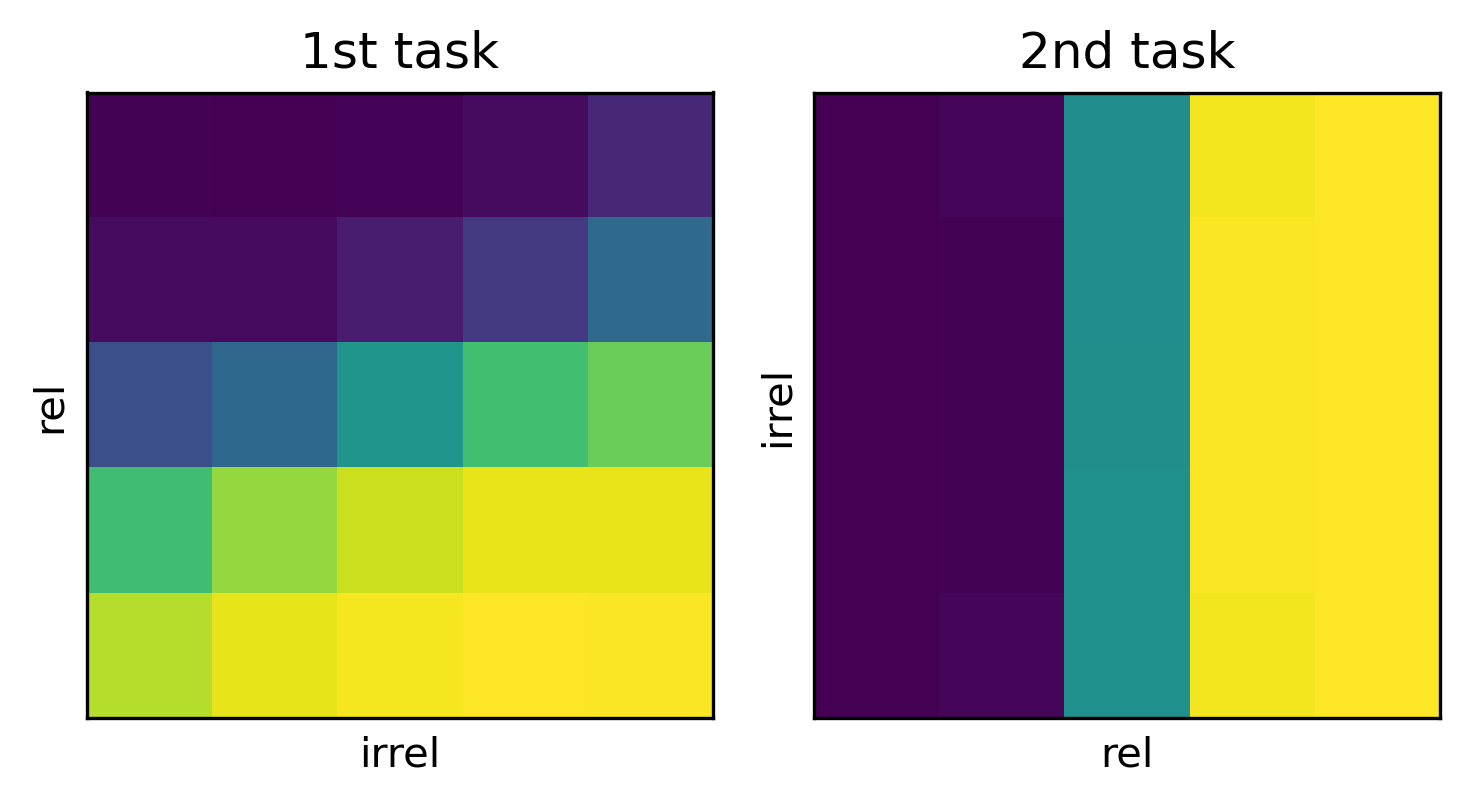

In [11]:
plotting.plot_basicstats(models = ["blobs_asha_200episodes_blocked_ojaall_1ctx_4"])

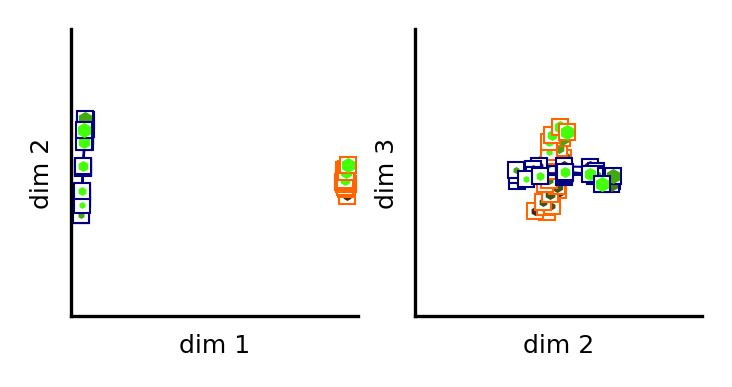

In [33]:
plotting.plot_mds(filename_embedding = "mds_blobs_asha_200episodes_blocked_ojaall_1ctx_4", 
filename_runs="blobs_asha_200episodes_blocked_ojaall_1ctx_4", thetas = (70,-15,-10),axlims=8.5)


## Figure 5: Modelling human learning with Oja + EMA (8 episodes)

### HP Grid Search

In [ ]:
plotting.plot_gridsearch_modelvalidation()

In [ ]:
plotting.plot_gridsearch_singlesubjects()

In [ ]:
plotting.plot_gridsearch_group()

### Accuracy

In [ ]:
plotting.plot_modelcomparison_accuracy()

### Sigmoids

In [ ]:
betas = plotting.plot_modelcomparison_sigmoids()

In [ ]:
plotting.plot_modelcomparison_betas(betas)

### Choice Matrices

In [ ]:
cmats = plotting.plot_modelcomparison_choicemats()

### Psychophysical Model

In [ ]:
plotting.plot_modelcomparison_choicemodel()

### Congruency Effect

In [ ]:
plotting.plot_modelcomparison_congruency(cmats)

## Figure 6: Neural predictions

### Hidden Layer RSA
Fit grid, orthogonal and diagonal model to data.  
Prediction: Orthogonal best in blocked, diagonal best in interleaved group

In [ ]:
betas = plotting.plot_modelcomparison_hiddenlayerRSA()

### Task Selectivity (%)

In [ ]:
plotting.plot_modelcomparison_taskselectivity(sluggishness=0.05)

### Readout Magnitude

In [ ]:
plotting.plot_modelcomparison_readout()

## Figure S1: Impact of training duration


In [35]:
# todo


## Figure S2: Replication of key findings with trees stimuli
1. task design
2. baseline model (fig 1 main but with baseline trees)
3. hebb model (fig 4 main but with hebb model)

In [36]:
# todo